# Tekstverlies in de Middelnederlandse ridderepiek

In [1]:
import numpy as np
np.random.seed(12345)
from scipy.special import erfinv
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
%matplotlib inline

## Data

In [2]:
mnl = pd.read_excel('mnl.xlsx', header=None, names=('text', 'witness'))
mnl.head(10)

,text,witness
0,Aiol (1),H1
1,Aiol (2),H2
2,Alexanders Geesten,"München, Bayerische Staatsbibliotheek, Cod. ge..."
3,Alexanders Geesten,H3
4,Alexanders Geesten,H4
5,Alexanders Geesten,H5
6,Alexanders Geesten,H6
7,Arturs doet,"Den Haag, KB, 129 A 10"
8,Arturs doet,"Rijksarchief te Antwerpen, Sint-Catharinakapit..."
9,Aubri de Borgengoen,H7


In [3]:
mnl.groupby('text').size().sort_values(ascending=False).head()

text
Historie van Troyen       16
Madelgijs                 10
Roman van Limborch        10
Karel ende Elegast         7
Parthonopeus van Bloys     6
dtype: int64

In [4]:
labels, mnl_counts = np.unique(mnl.groupby('text').size(), return_counts=True)
print(mnl_counts)

[42 13  6  3  3  1  1  2  1]


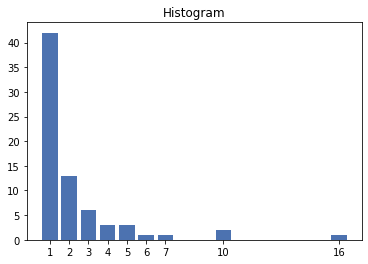

In [5]:
plt.bar(labels, mnl_counts, align='center')
plt.title('Histogram')
plt.gca().set_xticks(labels);

In [6]:
def species_richness(counts):
    return np.sum(counts > 0)

print('# unieke teksten:', species_richness(mnl.groupby('text').size()))
print('# unieke handschriften:', len(mnl))

# unieke teksten: 72
# unieke handschriften: 162


Waarom spreken we over *bias*? Omdat het belang of aandeel van de huidige observaties vrij consequent wordt over-schat: indien er nieuwe observaties worden bijgevonden, neemt het gewicht van de oude observaties immers proportioneel gesproken telkens wat af. We kennen bijvoorbeeld de volgende handschriften van de *Historie van Troyen*:

In [7]:
hvt = mnl[mnl['text'] == 'Historie van Troyen']
print(len(hvt))
hvt

16


,text,witness
124,Historie van Troyen,"Brussel, KBR, IV 927"
125,Historie van Troyen,"Brussel, KBR, 15.589-623"
126,Historie van Troyen,H106
127,Historie van Troyen,H107
128,Historie van Troyen,H108
129,Historie van Troyen,H109
130,Historie van Troyen,H110
131,Historie van Troyen,H111
132,Historie van Troyen,H112
133,Historie van Troyen,H113


Dit gebeurt er bijvoorbeeld met het relatieve belang van 'H112', als er een nieuw fragment opduikt (wat recent ook echt is gebeurd):

In [8]:
print('Proportioneel aandeel in de HvT-traditie:', 1 / len(hvt), 'vs', 1 / (len(hvt) + 1))
print('Proportioneel aandeel in de volledige traditie:', 1 / len(mnl), 'vs', 1 / (len(mnl) + 1))

Proportioneel aandeel in de HvT-traditie: 0.0625 vs 0.058823529411764705
Proportioneel aandeel in de volledige traditie: 0.006172839506172839 vs 0.006134969325153374


## Jackknife

We willen dus de bias in deze dataset dus berekenen en gebruik om bepaalde tellingen, zoals het aantal soorten, op een verantwoord manier naar boven bij te stellen. Een eenvoudige, op dit moment al ietwat verouderde methode is de zogenaamde *first-order jackknife*, het 'knipmes van de eerste orde'. We itereren over alle handschriften en laten telkens één tekstgetuige weg, waarna we opnieuw de soortenrijkdom in de iets verkleinde dataset berekenen. Vervolgens nemen we gemiddelde van de verkregen waarden en we berekenen hoe ver we van de rijkdom van de volledige set verwijderd waren. Deze bias kan vervolgens verrekend worden door deze af te trekken van de oncorrigeerde soortenrijkdom:

In [9]:
def jackknife(data, conf_lvl = .95):
    jack_stat = species_richness(data)
    
    x = np.array(sum([[i]*c for i, c in enumerate(data, 1)], []))
    index = np.arange(x.shape[0])
    
    vals = []
    for i in range(x.shape[0]):
        t = x[index != i]
        vals.append(species_richness(np.bincount(t)))
    
    mean_jack_stat = np.mean(vals)
    bias = (x.shape[0]-1) * (mean_jack_stat - jack_stat)
    
    estimate = jack_stat - bias
    
    std_err = np.sqrt((x.shape[0] - 1) * np.mean((mean_jack_stat - vals) * (mean_jack_stat - vals), axis=0))    
    
    z_score = np.sqrt(2.0) * erfinv(conf_lvl)
    conf_interval = estimate + z_score * np.array((-std_err, std_err))
    
    return estimate, std_err, conf_interval

results = jackknife(mnl.groupby('text').size())
print('jackknife-estimate (order=1):', results[0])

jackknife-estimate (order=1): 113.74074074073964


Deze berekening is ook vrij eenvoudig analytisch uit te voeren:

In [10]:
num_per_text = mnl.groupby('text').size()

Het totale aantal unieke teksten is *t*:

In [11]:
t = species_richness(num_per_text)
t

72

Het aantal teksten dat slechts één keer voorkomt is *s*:

In [12]:
s = sum(num_per_text == 1)
s

42

Gemiddeld bekomen we dus deze afwijking:

In [13]:
mu = (((t - s) * t) + (s * (t - 1))) / t
mu

71.41666666666667

Zodat we de bias als volgt kunnen vaststellen:

In [14]:
bias = (t - 1) * (mu - t)
bias

-41.41666666666633

En als volgt kunnen we dit verrekenen:

In [15]:
t - bias

113.41666666666633

## Chao

Basisformule, gebaseerd op 1-tjes en 2-tjes:

In [16]:
def chao_richness(x):
    x, n = x[x > 0], x.sum()
    t = x.shape[0]
    f1, f2 = (x == 1).sum(), (x == 2).sum()
    return t + (n - 1) / n * ((f1 ** 2 / 2 / f2) if f2 > 0 else (f1 * (f1 - 1) / 2))

Levert al een hogere, waarschijnlijk meer realistische, schatting op -- hoewel dit nog steeds een theoretische ondergrens is voor het reële tekstverlies.

In [17]:
chao_richness(num_per_text)

139.4273504273504

Monsteringsproces om variantie in kaart te brengen:

In [18]:
def bt_prob(x):
    x, n = x[x > 0], x.sum()
    f1, f2 = (x == 1).sum(), (x == 2).sum()
    C = 1 - f1 / n * (((n - 1) * f1 / ((n - 1) * f1 + 2 * f2)) if f2 > 0 else
                      ((n - 1) * (f1 - 1) / ((n - 1) * (f1 - 1) + 2)) if f1 > 0 else
                      0)
    W = (1 - C) / np.sum(x / n * (1 - x / n) ** n)
    p = x / n * (1 - W * (1 - x / n) ** n)
    f0 = np.ceil(((n - 1) / n * f1 ** 2 / (2 * f2)) if f2 > 0 else
                 ((n - 1) / n * f1 * (f1 - 1) / 2))
    p0 = (1 - C) / f0
    p = np.hstack((p, np.array([p0 for i in np.arange(f0)])))
    return p


def bootstrap(x, n_iter=1000, conf=.95):
    # define a multinomial probability distribution
    # for the bootstrap procedure to sample from:
    p, n = bt_prob(x), x.sum()
    data_bt = np.random.multinomial(n, p, n_iter)
    
    pro = np.array([chao_richness(row) for row in data_bt])
    
    pro_mean = pro.mean(0)
    
    lci_pro = -np.quantile(pro, (1 - conf) / 2, axis=0) + pro_mean
    uci_pro = np.quantile(pro, 1 - (1 - conf) / 2, axis=0) - pro_mean

    sd_pro = np.std(pro, axis=0)

    pro = pro_mean - pro
    return (lci_pro, uci_pro, sd_pro, pro)

In [19]:
def chao_estimate(x, n_iter=1000, conf=0.95):
    pro = chao_richness(x)
    (lci_pro, uci_pro, sd_pro, bt_pro) = bootstrap(x, n_iter=n_iter, conf=conf)
    lci_pro, uci_pro = pro - lci_pro, pro + uci_pro
    bt_pro = pro - bt_pro
    return (lci_pro, uci_pro, bt_pro, pro)

In [20]:
lci_pro, uci_pro, bt_pro, pro = chao_estimate(num_per_text, n_iter=1000)
print('pro:', pro)
print('lci_pro:', lci_pro)
print('uci_pro:', uci_pro)

pro: 139.4273504273504
lci_pro: 102.30003743193446
uci_pro: 216.3057678846093


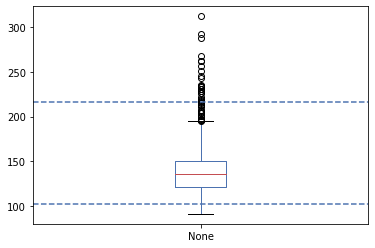

In [21]:
ax = pd.Series(bt_pro).plot.box()
ax.axhline(lci_pro, ls='--')
ax.axhline(uci_pro, ls='--');

### Simulation 1

In [22]:
def sample_lnorm(s_pool, n_sims, cv=1):
    """
    n_sims = sample size
    s_pool = population size, num of distinct species
    """
    mu = n_sims / s_pool
    sd = mu * cv
    sigma = np.sqrt(np.log(sd ** 2 / mu ** 2 + 1))
    mu = np.log(mu) - sigma ** 2 / 2
    pop = np.random.lognormal(mean=mu, sigma=sigma, size=s_pool)
    _, pop = np.unique(np.random.choice(s_pool, size=n_sims, p=pop / pop.sum()), return_counts=True)
    return pop

In [23]:
pop = sample_lnorm(200, 600)
pd.Series(pop).describe()

count    158.000000
mean       3.797468
std        3.948328
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       21.000000
dtype: float64

In [60]:
reps, s_pool, cv = 200, 150, 0.937
sample_sizes = range(50, 350, 50)

results = []
for i, n_sim in enumerate(sample_sizes):
    for j in range(reps):
        pop = sample_lnorm(s_pool, n_sims=n_sim, cv=cv)
        results.append({'sample size': n_sim, 'S': jackknife(pop)[0], 'estimator': 'Jackknife'})
        results.append({'sample size': n_sim, 'S': chao_richness(pop), 'estimator': 'Chao & Jost'})
S_df = pd.DataFrame(results)

In [61]:
S_df = pd.DataFrame(results)
S_df.head(20)

,S,estimator,sample size
0,70.380000,Jackknife,50
1,98.861250,Chao & Jost,50
2,77.280000,Jackknife,50
3,200.760000,Chao & Jost,50
4,65.440000,Jackknife,50
5,86.020000,Chao & Jost,50
6,73.320000,Jackknife,50
7,181.610000,Chao & Jost,50
8,65.440000,Jackknife,50
9,86.020000,Chao & Jost,50


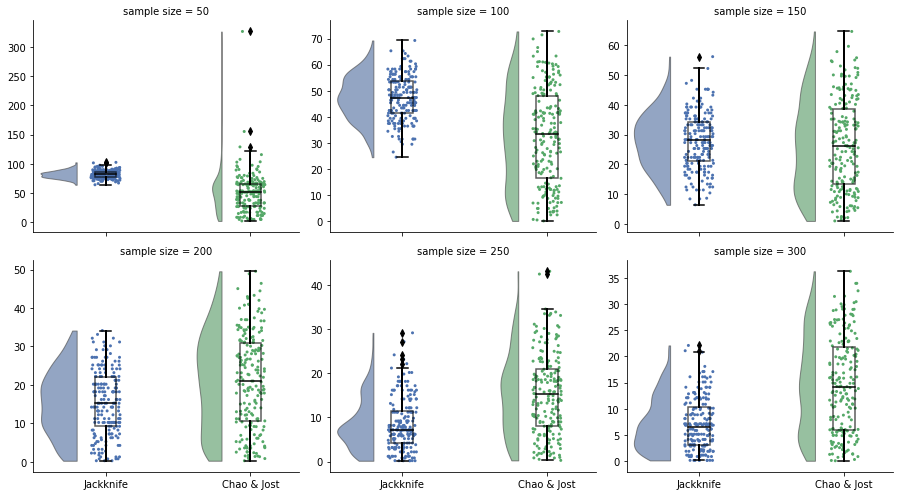

In [62]:
import ptitprince as pt
import seaborn as sns

S_df = S_df.replace([np.inf, -np.inf], np.nan).dropna() 
S_df['RMSE'] = np.sqrt((s_pool - S_df['S']) ** 2)

g = sns.FacetGrid(S_df, col="sample size", col_wrap=3, height=3.5, sharey=False, aspect=1.2)
g = g.map_dataframe(pt.RainCloud, x="estimator", y="RMSE", data=S_df, palette=None,
                    orient="v", ax=g.axes, alpha=0.65, bw=.3, width_viol=0.5)

## Simulation 2

In [41]:
richnesses = range(100, 500, 100)
sample_sizes = range(50, 500, 50)
iterations, cv = 50, 0.937
results = []

from itertools import product
from tqdm import tqdm

for richness, sample_size in tqdm(list(product(richnesses, sample_sizes))):
    for i in range(iterations):
        pop = sample_lnorm(richness, n_sims=sample_size, cv=cv)
        estimate = chao_richness(pop)
        #estimate = jackknife(pop)[0]
        results.append((sample_size, estimate, richness))
    
results = pd.DataFrame(results, columns=('sample_size', 'estimate', 'richness'))

100%|██████████| 36/36 [00:00<00:00, 151.78it/s]


In [42]:
results['RMSE'] = np.sqrt((results['richness'] - results['estimate']) ** 2)
results.head(10)

,sample_size,estimate,richness,RMSE
0,50,79.432000,100,20.568000
1,50,62.645000,100,37.355000
2,50,90.448000,100,9.552000
3,50,142.041667,100,42.041667
4,50,106.681667,100,6.681667
5,50,106.681667,100,6.681667
6,50,83.320000,100,16.680000
7,50,106.681667,100,6.681667
8,50,77.405000,100,22.595000
9,50,60.351111,100,39.648889


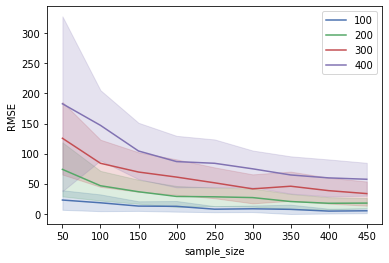

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

for idx, group in results.groupby('richness'):
    label = str(group['richness'].unique()[0])
    ax = sns.lineplot(x="sample_size", y="RMSE", ci= 'sd', data=group, label=label)
plt.legend();

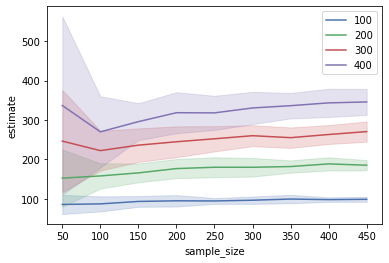

In [44]:
for idx, group in results.groupby('richness'):
    label = str(group['richness'].unique()[0])
    ax = sns.lineplot(x="sample_size", y="estimate", ci= 'sd', data=group, label=label)
plt.legend();

## Simulation 3

In [31]:
counts = np.bincount(mnl.groupby('text').size())[1:] # ignore zero
print(counts)

[42 13  6  3  3  1  1  0  0  2  0  0  0  0  0  1]


In [32]:
x = np.array(sum([[i]*c for i, c in enumerate(counts, 1)], []))
print(x)

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  2  2  2  2  3  3  3  3  3  3  4  4  4  5  5  5  6  7 10 10 16]


Set a conservative growth or mutation rate:

In [33]:
prop_new = x[x==1].sum() / x.sum()
prop_new

0.25925925925925924

In [36]:
growth_rates = range(1, 100)
iterations = 25

estimates = []

from tqdm import tqdm

for rate in tqdm(growth_rates):
    for it in range(iterations):
        new_pop = x.copy()
        mutations = np.random.choice(2, rate, p=[1 - prop_new, prop_new])
        for mutation in mutations:
            if mutation:
                new_pop = np.append(new_pop, [1])
            else:
                species = np.arange(len(new_pop))
                probas = new_pop / new_pop.sum()
                idx = np.random.choice(species, 1, p=probas)[0]
                new_pop[idx] += 1
        
        #estimate = jackknife(new_pop)[0]
        estimate = chao_estimate(new_pop)[0]
        
        estimates.append((rate, estimate))

100%|██████████| 99/99 [00:57<00:00,  1.73it/s]


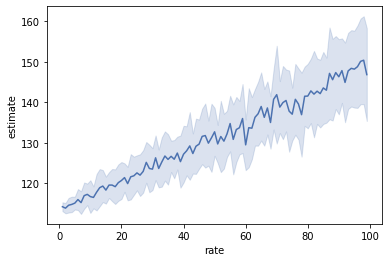

In [35]:
estimates = pd.DataFrame(estimates, columns=('rate', 'estimate'))
ax = sns.lineplot(x="rate", y="estimate", ci= 'sd', data=estimates)